In [2]:
import numpy as np
import pandas as pd
#from google.colab import drive
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#from tqdm.notebook import tqdm
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
#from hdbscan import hdbscan
#from sklearn.cluster import HDBSCAN
#from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

In [3]:
sns.set_theme()

In [4]:
RANDOM_SEED = 72
np.random.seed(RANDOM_SEED)

# Download CIC IDS 2017

[Este](https://www.unb.ca/cic/datasets/ids-2017.html) conjunto de dados contém informações sobre fluxos de rede, representando tanto o tráfego benigno quanto ataques populares. Para o ambiente de teste desta coleta de dados, uma rede foi configurada para o atacante e uma rede separada foi configurada para as vítimas, esta última contendo firewalls, roteadores, switches, servidores e estações de trabalho em execução em diferentes versões dos sistemas operacionais Windows e Linux. Para gerar o tráfego benigno, os autores utilizaram um sistema desenvolvido por eles mesmos, que então extraiu o comportamento abstrato de 25 usuários com base em diferentes protocolos de aplicação. Os dados foram coletados ao longo de cinco dias de atividade de rede e foram processados para extrair mais de 80 features do conjunto de dados usando a ferramenta CICFlowMeter8.


In [4]:
#!wget http://205.174.165.80/CICDataset/CIC-IDS-2017/Dataset/MachineLearningCSV.zip
#!gdown '1WtbUHBpANHLMVVHuaFr9-pGUyeW6QhdD' -O CIC_IDS_2017.zip

Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id='1WtbUHBpANHLMVVHuaFr9-pGUyeW6QhdD' 



In [5]:
#!tar -xf CIC_IDS_2017.zip

tar: Error opening archive: Failed to open 'CIC_IDS_2017.zip'


# Carregando os dados

In [5]:
df_list = []
for file in os.listdir('../../../Dados/MachineLearningCVE/'):
  df_aux = pd.read_csv(f'../../../Dados/MachineLearningCVE/{file}')
  df_list.append(df_aux)
df = pd.concat(df_list, ignore_index=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max         

In [ ]:
list(df.columns)[:]

[' Destination Port',
 ' Flow Duration',
 ' Total Fwd Packets',
 ' Total Backward Packets',
 'Total Length of Fwd Packets',
 ' Total Length of Bwd Packets',
 ' Fwd Packet Length Max',
 ' Fwd Packet Length Min',
 ' Fwd Packet Length Mean',
 ' Fwd Packet Length Std',
 'Bwd Packet Length Max',
 ' Bwd Packet Length Min',
 ' Bwd Packet Length Mean',
 ' Bwd Packet Length Std',
 'Flow Bytes/s',
 ' Flow Packets/s',
 ' Flow IAT Mean',
 ' Flow IAT Std',
 ' Flow IAT Max',
 ' Flow IAT Min',
 'Fwd IAT Total',
 ' Fwd IAT Mean',
 ' Fwd IAT Std',
 ' Fwd IAT Max',
 ' Fwd IAT Min',
 'Bwd IAT Total',
 ' Bwd IAT Mean',
 ' Bwd IAT Std',
 ' Bwd IAT Max',
 ' Bwd IAT Min',
 'Fwd PSH Flags',
 ' Bwd PSH Flags',
 ' Fwd URG Flags',
 ' Bwd URG Flags',
 ' Fwd Header Length',
 ' Bwd Header Length',
 'Fwd Packets/s',
 ' Bwd Packets/s',
 ' Min Packet Length',
 ' Max Packet Length',
 ' Packet Length Mean',
 ' Packet Length Std',
 ' Packet Length Variance',
 'FIN Flag Count',
 ' SYN Flag Count',
 ' RST Flag Count',
 ' P

Algumas colunas tem seus nomes iniciados com espaços ou finalizados com espaços. Vamos remover esses espaços não úteis para ajustar o nome das colunas.

In [ ]:
def remove_initial_and_ending_spaces(name):
    regex = r'^(?:\s+)?(?P<gp>.+?)(?:\s+)?$'
    mo = re.search(regex, name)
    if mo is not None:
      return mo['gp']
    else:
      print(f'Deu erro em: {name}')
      return name

In [ ]:
for col in df.columns:
    df = df.rename({col:remove_initial_and_ending_spaces(col)}, axis='columns')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Destination Port             int64  
 1   Flow Duration                int64  
 2   Total Fwd Packets            int64  
 3   Total Backward Packets       int64  
 4   Total Length of Fwd Packets  int64  
 5   Total Length of Bwd Packets  int64  
 6   Fwd Packet Length Max        int64  
 7   Fwd Packet Length Min        int64  
 8   Fwd Packet Length Mean       float64
 9   Fwd Packet Length Std        float64
 10  Bwd Packet Length Max        int64  
 11  Bwd Packet Length Min        int64  
 12  Bwd Packet Length Mean       float64
 13  Bwd Packet Length Std        float64
 14  Flow Bytes/s                 float64
 15  Flow Packets/s               float64
 16  Flow IAT Mean                float64
 17  Flow IAT Std                 float64
 18  Flow IAT Max                 int64  
 19  

# Limpando os dados

É necessário limpar os dados realizando:
- Descarte de registros duplicados
- Descarte de registros com valores NaN (Not a Number)/ Null / NA (Not Available)
- Evitar registros com valores não finitos. Nesse caso, uma abordagem válida é substituirmos os mesmos pelo maior valor finito presente no dataset.

Registros duplicados

In [ ]:
df[df.duplicated()]

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
2109,80,77,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2257,443,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2749,443,49,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2862,443,4,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2877,443,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830701,53,179,2,2,46,46,23,23,23.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830725,53,161,2,2,82,114,41,41,41.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830726,53,212,2,2,84,162,42,42,42.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830731,443,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [ ]:
df[~df.duplicated()]

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830738,53,32215,4,2,112,152,28,28,28.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830739,53,324,2,2,84,362,42,42,42.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830740,58030,82,2,1,31,6,31,0,15.5,21.92031,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830741,53,1048635,6,2,192,256,32,32,32.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [ ]:
# Descartando duplicadas
initial_len = df.shape[0]
df = df.drop_duplicates()
print(f'Tamanho inicial: {initial_len}, tamanho final {df.shape[0]} | Descartadas {initial_len - df.shape[0]} duplicadas')

Tamanho inicial: 2830743, tamanho final 2522362 | Descartadas 308381 duplicadas


Registros com valores Null/NaN/NA

In [ ]:
df.columns[df.isna().any(axis=0)]

Index(['Flow Bytes/s'], dtype='object')

In [ ]:
df[df.isna().any(axis=1)][['Flow Bytes/s']]

,Flow Bytes/s
6796,NaN
14739,NaN
15047,NaN
209728,NaN
238569,NaN
...,...
2740049,NaN
2767532,NaN
2791593,NaN
2809052,NaN


In [ ]:
# Descartando registros com valores NaN/Null/NA
initial_len = df.shape[0]
df = df.dropna()
print(f'Tamanho inicial: {initial_len}, tamanho final {df.shape[0]} | Descartados {initial_len - df.shape[0]} registros com valores NA')

Tamanho inicial: 2522362, tamanho final 2522009 | Descartados 353 registros com valores NA


Registros com valores não finitos

In [ ]:
df_columns_isfinite = np.isfinite(df.drop(['Label'], axis='columns')).all(axis=0)
df_columns_isfinite[df_columns_isfinite == False]

Flow Bytes/s      False
Flow Packets/s    False
dtype: bool

In [ ]:
df = df.reset_index(drop=True)

In [ ]:
df_rows_isfinite = np.isfinite(df.drop(['Label'], axis='columns')).all(axis=1)
inf_indexes = df_rows_isfinite[df_rows_isfinite == False].index
df.iloc[inf_indexes][['Flow Bytes/s', 'Flow Packets/s', 'Flow Duration']]

,Flow Bytes/s,Flow Packets/s,Flow Duration
65,inf,inf,0
1767,inf,inf,0
1890,inf,inf,0
3365,inf,inf,0
8001,inf,inf,0
...,...,...,...
2515309,inf,inf,0
2515565,inf,inf,0
2516784,inf,inf,0
2516908,inf,inf,0


In [ ]:
# Evitando registros com valores não finitos
max_finite_flow_packets_per_sec = df[np.isfinite(df['Flow Packets/s'])]['Flow Packets/s'].max()
max_finite_flow_bytes_per_sec = df[np.isfinite(df['Flow Bytes/s'])]['Flow Bytes/s'].max()

df.loc[df['Flow Packets/s'] == np.inf, 'Flow Packets/s'] = max_finite_flow_packets_per_sec
df.loc[df['Flow Bytes/s'] == np.inf, 'Flow Bytes/s'] = max_finite_flow_bytes_per_sec

# Mini análise exploratória

### Quantidade de instâncias benignas x maliciosas

<Axes: xlabel='Label', ylabel='count'>

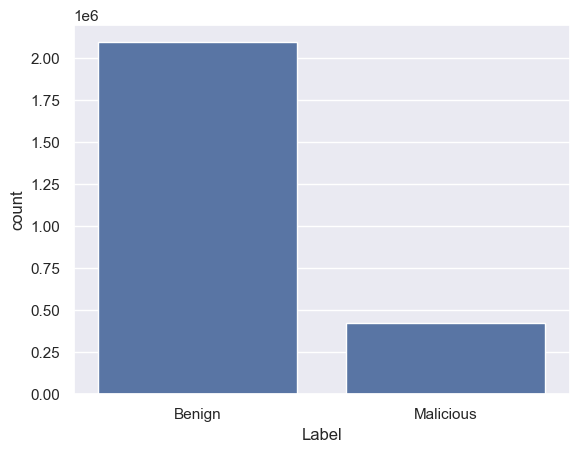

In [ ]:
sns.countplot(data=df['Label'].apply(lambda label: 'Malicious' if label != 'BENIGN' else 'Benign').to_frame(), x='Label')

**Dados não balanceados**. Impactos:
- Dificuldade de treinar modelos supervisionados
- Dificuldade de avaliar resultados com métricas tradicionais como acurácia

### Quantidade de instâncias por tipo de ataque

Abaixo está um descritivo para os ataques do dataset:

**DoS (Denial of Service)**: Esses ataques, como "DoS Hulk", "DoS GoldenEye", "DoS Slowloris", "DoS Slowhttptest" e "DDoS" visam tornar temporariamente uma máquina ou recurso de rede indisponível, sendo diferenciados pelo protocolo e estratégia usados para causar a negação de serviço. No caso do "DDoS", várias máquinas Windows 8.1 foram usadas para enviar solicitações UDP, TCP e HTTP.

**FTP Patator" e "SSH Patator**: Usam o software Patator para adivinhar senhas por força bruta com o uso de listas de palavras.

**Web - Brute Force**: Usa força bruta em uma aplicação com listas de palavras.

**Web - Injeção de SQL**: Esse ataque explora vulnerabilidades em máquinas conectadas publicamente à Internet usando injeção SQL.

**Web - XSS (Cross-Site Scripting)**: Representa injeções de scripts em aplicativos da web, visando a execução de ações maliciosas por outros usuários do aplicativo.

**PortScan**: Realizados com a ferramenta NMap, esses ataques buscam informações sobre os serviços e portas abertas em um alvo.

**Bot**: Esse ataque tem várias possibilidades, como roubo de dados, envio de spam e acesso ao dispositivo. .

**Infiltration**: Baseado na infecção de uma máquina após um usuário abrir um arquivo malicioso.

In [ ]:
df['Label'] = df['Label'].replace({'Web Attack � Brute Force':'Brute Force', 'Web Attack � XSS':'XSS', 'Web Attack � Sql Injection':'Sql Injection'})

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, 'DoS Hulk'),
  Text(1, 0, 'DDoS'),
  Text(2, 0, 'PortScan'),
  Text(3, 0, 'DoS GoldenEye'),
  Text(4, 0, 'FTP-Patator'),
  Text(5, 0, 'DoS slowloris'),
  Text(6, 0, 'DoS Slowhttptest'),
  Text(7, 0, 'SSH-Patator'),
  Text(8, 0, 'Bot'),
  Text(9, 0, 'Brute Force'),
  Text(10, 0, 'XSS'),
  Text(11, 0, 'Infiltration'),
  Text(12, 0, 'Sql Injection'),
  Text(13, 0, 'Heartbleed')])

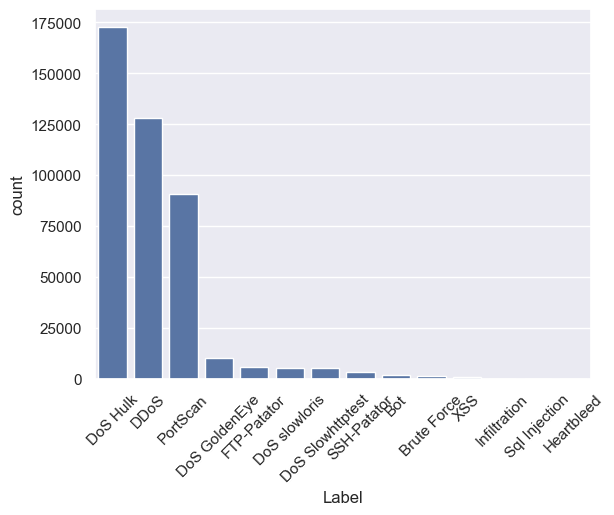

In [ ]:
sns.countplot(data=df.query('Label != "BENIGN"')[['Label']], x='Label', order = df.query('Label != "BENIGN"')['Label'].value_counts().index)
plt.xticks(rotation=45)

Ataques menos representados

([0], [Text(0, 0, 'Heartbleed')])

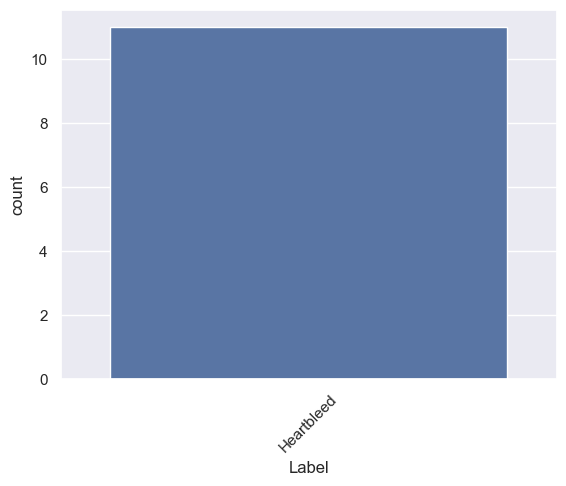

In [ ]:
#N_LESS_REPRESENTED_LABELS = 5
N_LESS_REPRESENTED_LABELS = 1

sns.countplot(data=df[df['Label'].isin(df.groupby('Label').size().sort_values(ascending=False)[(-1)*N_LESS_REPRESENTED_LABELS:].index)], x='Label')
plt.xticks(rotation=45)

In [ ]:
df

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2522004,53,32215,4,2,112,152,28,28,28.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2522005,53,324,2,2,84,362,42,42,42.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2522006,58030,82,2,1,31,6,31,0,15.5,21.92031,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2522007,53,1048635,6,2,192,256,32,32,32.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


### Estatísticas dos dados

In [ ]:
interesting_cols = ['Flow Duration', 'Flow Bytes/s', 'Total Fwd Packets', 'Average Packet Size', 'SYN Flag Count']
df[interesting_cols].describe()

,Flow Duration,Flow Bytes/s,Total Fwd Packets,Average Packet Size,SYN Flag Count
count,2.522009e+06,2.522009e+06,2.522009e+06,2.522009e+06,2.522009e+06
mean,1.658364e+07,2.404467e+06,1.027750e+01,2.123412e+02,4.874487e-02
std,3.522618e+07,5.254864e+07,7.942294e+02,3.454504e+02,2.153342e-01
min,-1.300000e+01,-2.610000e+08,1.000000e+00,0.000000e+00,0.000000e+00
25%,2.080000e+02,1.194510e+02,2.000000e+00,9.000000e+00,0.000000e+00
50%,5.058700e+04,3.722028e+03,2.000000e+00,8.075000e+01,0.000000e+00
75%,5.330376e+06,1.079162e+05,6.000000e+00,1.796923e+02,0.000000e+00
max,1.200000e+08,2.071000e+09,2.197590e+05,3.893333e+03,1.000000e+00


# Dividindo dados nos conjuntos de treino, validação e teste

**Conjunto de treino**

Para a detecção de anomalias, vamos usar somente os dados que representam o tráfego benigno para o conjunto de treino. Dessa forma, os algoritmos de clustering vão ser capazes de identificar padrões e desvios em relação ao comportamento normal (benigno) dos dados.

**Conjuntos de validação e teste**

Porém, devem ser incluídos dados que representam o tráfego maliciosos nos conjuntos de validação e teste. Esses dados maliciosos no conjunto de validação são importantes para que possamos definir um *threshold* para que seja possível detectar anomalias. Além disso, os dados maliciosos também precisam ser incluídos no conjunto de teste para que possamos avaliar o desempenho do nosso modelo.

#### KMeans

In [ ]:
df_train = df.query('Label == "BENIGN"').sample(frac=0.6)#, random_state=RANDOM_SEED)
df_val_test = df.drop(df_train.index)

df_train = df_train.reset_index(drop=True)
df_val_test = df_val_test.reset_index(drop=True)

X_train = df_train.drop('Label', axis='columns')

In [ ]:
X_val, X_test, classes_val, classes_test = train_test_split(df_val_test.drop('Label', axis='columns'), df_val_test['Label'], test_size=0.65, stratify=df_val_test['Label']) #random_state=RANDOM_SEED)

X_val, X_test = X_val.reset_index(drop=True), X_test.reset_index(drop=True)
classes_val, classes_test =  classes_val.reset_index(drop=True), classes_test.reset_index(drop=True)

y_val, y_test = classes_val.apply(lambda c: 0 if c == 'BENIGN' else 1), classes_test.apply(lambda c: 0 if c == 'BENIGN' else 1)

In [ ]:
del df_train, df_val_test

#### DBSCAN

In [ ]:
true_labels = df['Label']

In [ ]:
true_labels

0          BENIGN
1          BENIGN
2          BENIGN
3          BENIGN
4          BENIGN
            ...  
2522004    BENIGN
2522005    BENIGN
2522006    BENIGN
2522007    BENIGN
2522008    BENIGN
Name: Label, Length: 2522009, dtype: object

In [ ]:
true_labels = true_labels.reset_index(drop=True)
true_labels = true_labels.apply(lambda c: 0 if c == 'BENIGN' else 1)

In [ ]:
df = df.drop('Label', axis='columns')
#df = df.drop(df.index)
df = df.reset_index(drop=True)

# Analisando correlação entre features

**Por que remover features?**

Vamos descartar features com alta correlação evitando passar informações redundantes ao modelo. Dessa forma, conseguiremos obter um modelo mais simples e com menor custo computacional.

#### KMeans

In [ ]:
def get_highly_correlated_features(correlation_matrix, threshold):
  correlated_pairs = []
  for i in range(len(correlation_matrix.columns)):
    for j in range(i):
      if abs(correlation_matrix.iloc[i, j]) > threshold:
        pair = (correlation_matrix.columns[i], correlation_matrix.columns[j])
        coefficient = correlation_matrix.iloc[i, j]
        correlated_pairs.append((pair, coefficient))
  return sorted(correlated_pairs, key= lambda pair: pair[1], reverse=True)


In [ ]:
corr_matrix = X_train.corr().abs()
correlation_list = get_highly_correlated_features(corr_matrix, 0.95)

In [ ]:
correlation_list[:10]

[(('SYN Flag Count', 'Fwd PSH Flags'), 1.0),
 (('CWE Flag Count', 'Fwd URG Flags'), 1.0),
 (('ECE Flag Count', 'RST Flag Count'), 1.0),
 (('Avg Fwd Segment Size', 'Fwd Packet Length Mean'), 1.0),
 (('Fwd Header Length.1', 'Fwd Header Length'), 1.0),
 (('Subflow Fwd Packets', 'Total Fwd Packets'), 1.0),
 (('Subflow Bwd Packets', 'Total Backward Packets'), 1.0),
 (('Avg Bwd Segment Size', 'Bwd Packet Length Mean'), 0.9999999999999993),
 (('Subflow Bwd Bytes', 'Total Length of Bwd Packets'), 0.9999998597678953),
 (('Subflow Fwd Bytes', 'Total Length of Fwd Packets'), 0.9999995091990549)]

In [ ]:
# Drop high correlated features in correlation list

f2drop = []
for feature_pair, _ in correlation_list:
  if feature_pair[0] not in f2drop and feature_pair[1] not in f2drop:
    f2drop.append(feature_pair[1])

In [ ]:
f2drop

['Fwd PSH Flags',
 'Fwd URG Flags',
 'RST Flag Count',
 'Fwd Packet Length Mean',
 'Fwd Header Length',
 'Total Fwd Packets',
 'Total Backward Packets',
 'Bwd Packet Length Mean',
 'Total Length of Bwd Packets',
 'Total Length of Fwd Packets',
 'Subflow Fwd Packets',
 'Subflow Bwd Packets',
 'Flow Duration',
 'Packet Length Mean',
 'Flow IAT Max',
 'Idle Mean',
 'Fwd IAT Total',
 'Fwd Packet Length Max',
 'Max Packet Length',
 'Bwd IAT Max',
 'Bwd IAT Mean',
 'Fwd IAT Max',
 'Fwd IAT Mean',
 'Idle Max']

A feature "Destination Port", também não fornece muita contribuição devido que a mesma está codificada com valores inteiros, indicando uma relação de grandeza, como 44720 > 80, que não apresenta sentido semântico quando se trata da porta de destino de um fluxo de rede.

In [ ]:
f2drop = f2drop + ['Destination Port']

In [ ]:
X_train = X_train.drop(f2drop, axis='columns')
X_val = X_val.drop(f2drop, axis='columns')
X_test = X_test.drop(f2drop, axis='columns')

#### DBSCAN

In [ ]:
def get_highly_correlated_features(correlation_matrix, threshold):
  correlated_pairs = []
  for i in range(len(correlation_matrix.columns)):
    for j in range(i):
      if abs(correlation_matrix.iloc[i, j]) > threshold:
        pair = (correlation_matrix.columns[i], correlation_matrix.columns[j])
        coefficient = correlation_matrix.iloc[i, j]
        correlated_pairs.append((pair, coefficient))
  return sorted(correlated_pairs, key= lambda pair: pair[1], reverse=True)


In [ ]:
df_corr_matrix = df.corr().abs()
df_correlation_list = get_highly_correlated_features(df_corr_matrix, 0.95)

In [ ]:
df_correlation_list[:10]

[(('SYN Flag Count', 'Fwd PSH Flags'), 1.0),
 (('CWE Flag Count', 'Fwd URG Flags'), 1.0),
 (('Avg Fwd Segment Size', 'Fwd Packet Length Mean'), 1.0),
 (('Fwd Header Length.1', 'Fwd Header Length'), 1.0),
 (('Subflow Fwd Packets', 'Total Fwd Packets'), 1.0),
 (('Subflow Bwd Packets', 'Total Backward Packets'), 1.0),
 (('Avg Bwd Segment Size', 'Bwd Packet Length Mean'), 0.9999999999999996),
 (('Subflow Bwd Bytes', 'Total Length of Bwd Packets'), 0.9999998601336004),
 (('Subflow Fwd Bytes', 'Total Length of Fwd Packets'), 0.9999993581446759),
 (('Total Backward Packets', 'Total Fwd Packets'), 0.9990701999505314)]

In [ ]:
df_f2drop = []
for feature_pair, _ in df_correlation_list:
  if feature_pair[0] not in df_f2drop and feature_pair[1] not in df_f2drop:
    df_f2drop.append(feature_pair[1])

In [ ]:
df_f2drop

['Fwd PSH Flags',
 'Fwd URG Flags',
 'Fwd Packet Length Mean',
 'Fwd Header Length',
 'Total Fwd Packets',
 'Total Backward Packets',
 'Bwd Packet Length Mean',
 'Total Length of Bwd Packets',
 'Total Length of Fwd Packets',
 'Subflow Fwd Packets',
 'Flow Duration',
 'Flow IAT Max',
 'Packet Length Mean',
 'RST Flag Count',
 'Subflow Bwd Packets',
 'Idle Mean',
 'Fwd IAT Max',
 'Max Packet Length',
 'Bwd Packet Length Max',
 'Fwd Packet Length Max',
 'Idle Max']

In [ ]:
df_f2drop = df_f2drop + ['Destination Port']

In [ ]:
df = df.drop(df_f2drop, axis='columns')

In [ ]:
del df_f2drop, df_correlation_list, df_corr_matrix

# Normalizando os dados

É importante normalizar os dados para lidar com diferentes escalas, sensibilidades a escalas e até mesmo melhorar o desempenho da convergência dos algoritmos.

Caso não seja realizada a normalização, um valor de 10000 para uma feature como "Flow Bytes/s" terá impacto similar ao modelo quanto um valor de 10000 para uma feature como "Flow Packets/s". Isso é prejudicial, pois o impacto desse valor para as duas features deve ser tratado de forma distinta, já que as mesmas têm escalas e sensibilidades também distintas.

#### KMeans

In [ ]:
std_scaler = StandardScaler()
std_scaler = std_scaler.fit(X_train)

norm_X_train = std_scaler.transform(X_train)
norm_X_val = std_scaler.transform(X_val)
norm_X_test = std_scaler.transform(X_test)

In [ ]:
del X_train, X_val, X_test

#### DBSCAN

In [ ]:
df_std_scaler = StandardScaler()
df_std_scaler = df_std_scaler.fit(df)

norm_df = df_std_scaler.transform(df)

In [ ]:
del df

# Detecção de Anomalias com o KMeans

Dado um grupo de amostras de dados, o objetivo do k-means é criar um número k de clusters de modo que cada amostra de dados pertença a um dos grupos formados. O primeiro passo para a construção dos clusters é selecionar aleatoriamente k centróides, que são representações do centro de cada cluster. De maneira mais simples, se cada amostra de dados pode ser representada por um ponto, o centróide de um grupo é um ponto no centro desse grupo. Em seguida, três outras etapas são repetidas para atualizar os grupos até que seus centróides tenham estabilizado e não mudem mais de lugar:

1. A distância euclidiana é calculada entre cada centróide e todas as amostras de dados.
2. Cada amostra é atribuída ao centróide mais próximo que forma os grupos;
3. Cada centróide de cluster é atualizado através da média da distância entre as amostras de dados dentro de cada cluster.


Porém, para que o algoritmo KMeans seja utilizado, precisamos informar um número K de clusters esperados. Uma forma de obter um número de clusters que melhor se adapte ao conjunto de dados é através da métrica de **silhouette score**. Essa métrica é calculada considerando as distâncias intra cluster e inter clusters de cada amostra do conjunto de dados.

Para saber mais sobre essa métrica [clique aqui](https://towardsdatascience.com/silhouette-coefficient-validating-clustering-techniques-e976bb81d10c)

In [ ]:
random_train_indexes = np.random.choice(norm_X_train.shape[0], int(norm_X_train.shape[0]*0.02), replace=False)
norm_X_train_subset = norm_X_train[random_train_indexes,:]

In [ ]:
k_list = list(range(12, 18))
inertia_score_list = list()
silhouette_score_list = []
for k in k_list:
    model_kmeans = KMeans(n_clusters=k, n_init=50)
    model_kmeans = model_kmeans.fit(norm_X_train_subset)
    s_score = silhouette_score(norm_X_train_subset, model_kmeans.predict(norm_X_train_subset))
    silhouette_score_list.append(s_score)
    inertia_score_list.append(model_kmeans.inertia_)

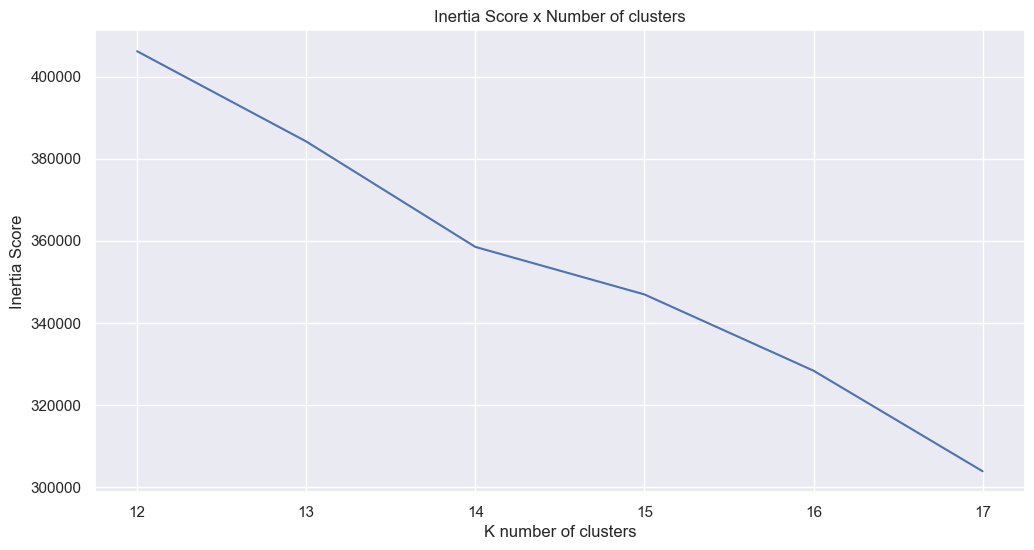

In [ ]:
fig_i, ax_i = plt.subplots(figsize=(12, 6))
ax_i.set_xlabel('K number of clusters')
ax_i.set_ylabel('Inertia Score')
ax_i.set_xticks(k_list)
ax_i.set_title('Inertia Score x Number of clusters')
ax_i.plot(k_list, inertia_score_list)

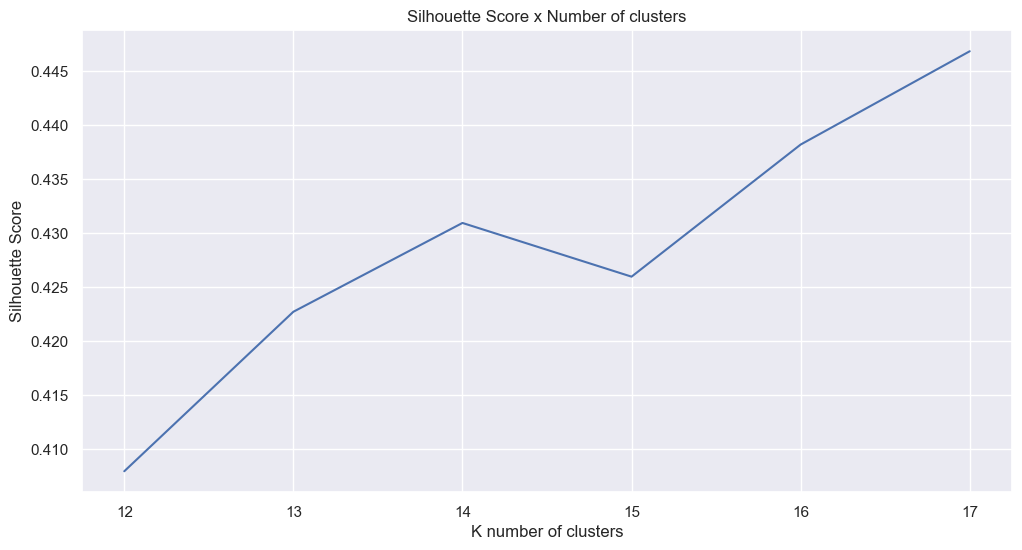

In [ ]:
fig, ax_s = plt.subplots(figsize=(12, 6))
ax_s.set_xlabel('K number of clusters')
ax_s.set_ylabel('Silhouette Score')
ax_s.set_xticks(k_list)
ax_s.set_title('Silhouette Score x Number of clusters')
ax_s.plot(k_list, silhouette_score_list)

In [ ]:
K_CLUSTERS = 16

In [ ]:
model_kmeans = KMeans(n_clusters=K_CLUSTERS, n_init=10)
model_kmeans = model_kmeans.fit(norm_X_train)

In [ ]:
def plot_pca(X, model_kmeans=None, print_centroids = False):
  pca = PCA(n_components=2)#, random_state=RANDOM_SEED)
  X_pca = pca.fit_transform(X)

  fig, ax = plt.subplots(figsize=(14, 6))
  ax.set_title('PCA Analysis')

  if print_centroids and model_kmeans is not None:
    cluster_centers_principal_components = pca.transform(model_kmeans.cluster_centers_)
    num_clusters = cluster_centers_principal_components.shape[0]

    X_clusters = model_kmeans.predict(X)

    # For each cluster, plot their respective X data instances
    for cluster in range(num_clusters):
      indexes = np.where(X_clusters == cluster)
      ax.scatter(X_pca[indexes, 0], X_pca[indexes, 1], s=1, c=plt.cm.tab20(cluster), label=f'Cluster#{cluster}')

    # For each cluster centroid, plot the centroid
    for i, cluster_center_pc in enumerate(cluster_centers_principal_components):
      ax.scatter(cluster_center_pc[0], cluster_center_pc[1], c='black', s=8, marker='x')
      ax.annotate(f'Cluster#{i}', (cluster_center_pc[0], cluster_center_pc[1]), size=10)
    ax.legend()

  else:
    ax.scatter(X_pca[:,0], X_pca[:,1], s=1)

C:\Users\henri\AppData\Local\Temp\ipykernel_10232\846414670.py:17: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X_pca[indexes, 0], X_pca[indexes, 1], s=1, c=plt.cm.tab20(cluster), label=f'Cluster#{cluster}')


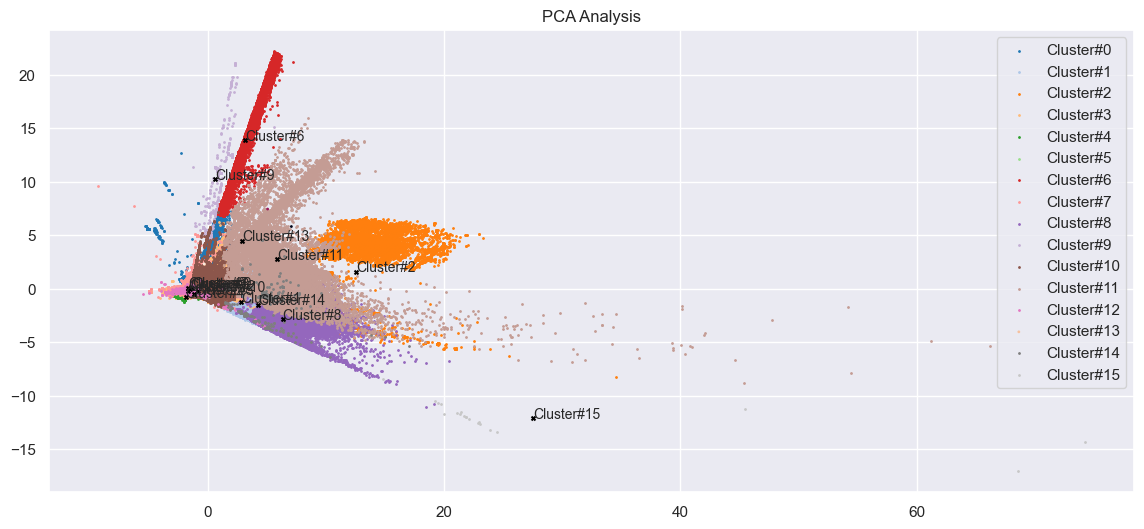

In [ ]:
plot_pca(norm_X_train, model_kmeans, print_centroids=True)

## Definindo um threshold e avaliando resultados

In [ ]:
def plot_roc_curve(y_true, y_score, max_fpr=1.0):
  fpr, tpr, thresholds = roc_curve(y_true, y_score)
  aucroc = roc_auc_score(y_true, y_score)
  plt.plot(100*fpr[fpr < max_fpr], 100*tpr[fpr < max_fpr], label=f'ROC Curve (AUC = {aucroc:.4f})')
  plt.xlim(-2,102)
  plt.xlabel('FPR (%)')
  plt.ylabel('TPR (%)')
  plt.legend()
  plt.title('ROC Curve and AUCROC')

In [ ]:
def get_tpr_per_attack(y_labels, y_pred):
  aux_df = pd.DataFrame({'Label':y_labels,'prediction':y_pred})
  total_per_label = aux_df['Label'].value_counts().to_dict()
  correct_predictions_per_label = aux_df.query('Label != "BENIGN" and prediction == True').groupby('Label').size().to_dict()
  tpr_per_attack = {}
  for attack_label, total in total_per_label.items():
    if attack_label == 'BENIGN':
      continue
    tp = correct_predictions_per_label[attack_label] if attack_label in correct_predictions_per_label else 0
    tpr = tp/total
    tpr_per_attack[attack_label] = tpr
  return tpr_per_attack

In [ ]:
def get_overall_metrics(y_true, y_pred):
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  acc = (tp+tn)/(tp+tn+fp+fn)
  tpr = tp/(tp+fn)
  fpr = fp/(fp+tn)
  precision = tp/(tp+fp)
  f1 = (2*tpr*precision)/(tpr+precision)
  return {'acc':acc,'tpr':tpr,'fpr':fpr,'precision':precision,'f1-score':f1}

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)
  group_counts = [f'{value:.0f}' for value in confusion_matrix(y_true, y_pred).ravel()]
  group_percentages = [f'{value*100:.2f}%' for value in confusion_matrix(y_true, y_pred).ravel()/np.sum(cm)]
  labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts, group_percentages)]
  labels = np.array(labels).reshape(2,2)
  sns.heatmap(cm, annot=labels, cmap='Oranges', xticklabels=['Predicted Benign', 'Predicted Malicious'], yticklabels=['Actual Benign', 'Actual Malicious'], fmt='')
  return

## Conjunto de validação

In [ ]:
val_centroids_distances = model_kmeans.transform(norm_X_val)
val_anomaly_scores = np.min(val_centroids_distances, axis=1)

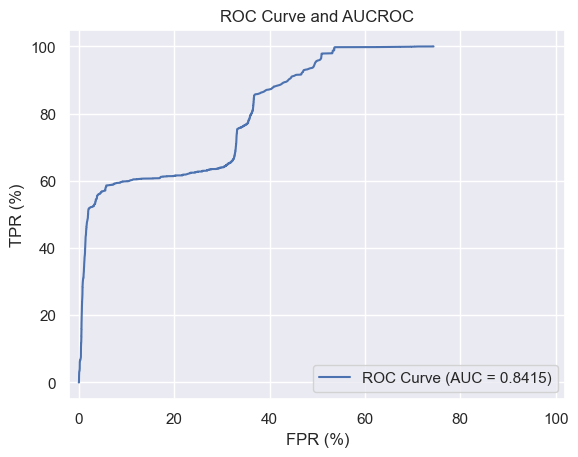

In [ ]:
plot_roc_curve(y_val, val_anomaly_scores)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val, val_anomaly_scores)
df_val_roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds})
df_val_roc['youden-index'] = df_val_roc['tpr'] - df_val_roc['fpr']
df_val_roc.sort_values('youden-index', ascending=False).drop_duplicates('fpr')

,fpr,tpr,thresholds,youden-index
12745,0.057558,0.586162,6.539496,0.528604
12743,0.057555,0.586149,6.539649,0.528594
12741,0.057551,0.586129,6.539985,0.528577
12747,0.057718,0.586169,6.525320,0.528451
12739,0.057548,0.585995,6.540568,0.528446
...,...,...,...,...
4,0.000221,0.000007,53.487802,-0.000215
5,0.000232,0.000007,53.487802,-0.000225
6,0.000239,0.000007,53.487793,-0.000232
8,0.000327,0.000027,45.363686,-0.000300


In [ ]:
BEST_VALIDATION_THRESHOLD = 8.714842

In [ ]:
y_val

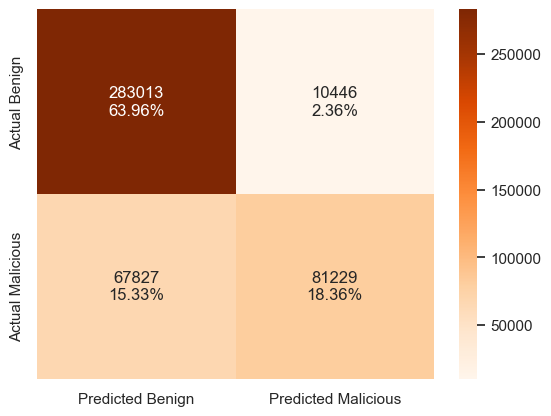

In [ ]:
plot_confusion_matrix(y_val, val_anomaly_scores > BEST_VALIDATION_THRESHOLD)

In [ ]:
get_overall_metrics(y_val, val_anomaly_scores > BEST_VALIDATION_THRESHOLD)

{'acc': 0.8231178604115115,
 'tpr': 0.5449562580506655,
 'fpr': 0.03559611393755175,
 'precision': 0.8860539950913553,
 'f1-score': 0.6748528440458437}

In [ ]:
get_tpr_per_attack(classes_val, val_anomaly_scores > BEST_VALIDATION_THRESHOLD)

{'DoS Hulk': 0.8612304945781539,
 'DDoS': 0.5464669910279873,
 'PortScan': 0.012898354673294114,
 'DoS GoldenEye': 0.5113888888888889,
 'FTP-Patator': 0.0009633911368015414,
 'DoS slowloris': 0.4397877984084881,
 'DoS Slowhttptest': 0.8387978142076503,
 'SSH-Patator': 0.0,
 'Bot': 0.020497803806734993,
 'Brute Force': 0.0,
 'XSS': 0.0,
 'Infiltration': 0.6153846153846154,
 'Sql Injection': 0.0,
 'Heartbleed': 1.0}

## Conjunto de teste

In [ ]:
test_centroids_distances = model_kmeans.transform(norm_X_test)
test_anomaly_scores = np.min(test_centroids_distances, axis=1)

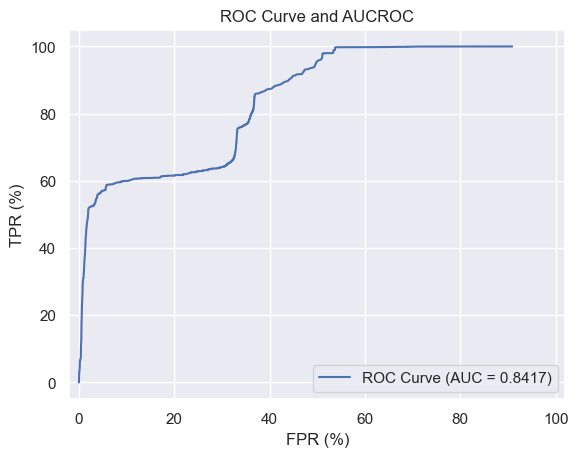

In [ ]:
plot_roc_curve(y_test, test_anomaly_scores)

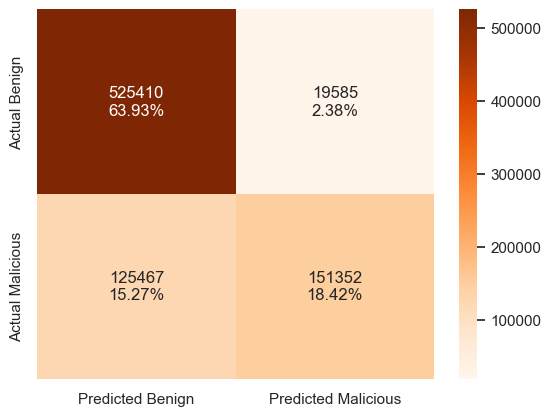

In [ ]:
plot_confusion_matrix(y_test, test_anomaly_scores > BEST_VALIDATION_THRESHOLD)

In [ ]:
get_overall_metrics(y_test, test_anomaly_scores > BEST_VALIDATION_THRESHOLD)

{'acc': 0.8234977744355779,
 'tpr': 0.5467543774090652,
 'fpr': 0.03593610950559179,
 'precision': 0.8854256246453371,
 'f1-score': 0.676046775475929}

In [ ]:
get_tpr_per_attack(classes_test, test_anomaly_scores > BEST_VALIDATION_THRESHOLD)

{'DoS Hulk': 0.8624833110814419,
 'DDoS': 0.5514120898930417,
 'PortScan': 0.013094592763247053,
 'DoS GoldenEye': 0.5026921926413401,
 'FTP-Patator': 0.0010370754472387865,
 'DoS slowloris': 0.4382857142857143,
 'DoS Slowhttptest': 0.835197174808711,
 'SSH-Patator': 0.0004780114722753346,
 'Bot': 0.029921259842519685,
 'Brute Force': 0.0,
 'XSS': 0.0,
 'Infiltration': 0.5652173913043478,
 'Sql Injection': 0.0,
 'Heartbleed': 1.0}

In [ ]:
del norm_X_test, norm_X_train, norm_X_val, norm_X_train_subset

# Detecção de Anomalias com DBSCAN

Próximos passos: Realizar a detecção de anomalias usando o DBSCAN

## Testes de Parâmetros (+Silhoutte score, +AUC score).

Primeiro, tentei descobrir como os parâmetros do DBSCAN funcionam, então fiz vários testes com várias possibilidades de combinações de parâmetros. Além disso, analisei o silhoutte score e o AUC das combinações.

Como são diversas combinações, requer um poder computacional gigantesco(principalmente pela quantidade de repetições), por isso, usei apenas uma fração bem pequena dos dados.

In [ ]:
RANDOM_SEED = 2375
np.random.seed(RANDOM_SEED)

In [ ]:
random_indexes = np.random.choice(norm_df.shape[0], int(norm_df.shape[0]*0.001), replace=False)
norm_df_subset = norm_df[random_indexes,:]
true_labels_subset = true_labels.iloc[random_indexes]

Usei o número da quantidade do subset para calcular a proporção do **min_samples**, será explicado posteriormente.

In [ ]:
len(norm_df_subset)

2522

Aqui eu fiz vários "for", um dentro do outro, testando os parâmetros mais importantes do DBSCAN: **metric**, **eps**, **min_sample**, **algorithm**. Vale salientar que o parâmetro **n_jobs** sempre irá ser **-1** em todas as partes desta atividade, pois é onde o uso do processador é maximizado(todos os núcleos ao mesmo tempo).

O teste consiste em verificar os parâmetros, número de clusters e silhouette score de cada combinação e fazer um ranking top 10 baseado no silhouette score.

In [ ]:
def aucroc(y_true, y_score, max_fpr=1.0):
  fpr, tpr, thresholds = roc_curve(y_true, y_score)
  aucroc = roc_auc_score(y_true, y_score)
  return aucroc

In [ ]:
# Lista de métricas do DBSCAN
metric_list = [
    'euclidean',
    'manhattan',
    'chebyshev',
    'correlation',
    'cityblock',
    'cosine',
    'hamming',
    'braycurtis',
    'canberra'
]    
    #'precomputed']

# Lista de algoritmos do DBSCAN
algorithm_list = ['auto']#, 'ball_tree', 'kd_tree', 'brute']

# Lista de quantidade d amostras mínimas
samples_n_list = list(range(max(2, int(len(norm_df_subset) * 0.0008)), int(len(norm_df_subset) * 0.0060))) #Preferi usar um min_sample adaptável a quantidade de dados.

# Lista de EPS
#eps_list = np.arange(2.35, 2.9, 0.015)
eps_list = np.arange(0.5, 4.0, 0.05)

# Lista dos scores do método silhouette
score_list = []

# Lista de combinações inválidas de métricas com algoritmos
invalid_combinations = [
    ('ball_tree', 'correlation'),
    ('ball_tree', 'cosine'),
    ('ball_tree', 'hamming'),
    ('ball_tree', 'braycurtis'),
    ('ball_tree', 'canberra'),
    ('kd_tree', 'correlation'),
    ('kd_tree', 'cosine'),
    ('kd_tree', 'hamming'),
    ('kd_tree', 'braycurtis'),
    ('kd_tree', 'canberra')
]

for m in metric_list:
    for a in algorithm_list:
        if (a, m) in invalid_combinations:
            continue  # Ignora combinação inválida
        else:
            for s in samples_n_list:
                for e in eps_list:
                    model_dbscan = DBSCAN(eps=e, min_samples=s, metric=m, algorithm=a, n_jobs=-1) # Treinamento

                    labels = model_dbscan.fit_predict(norm_df_subset) # Labels

                    predicoes = model_dbscan.labels_

                    # Silhouette score e número de clusters
                    s_score = 0
                    if len(np.unique(labels)) > 1:  # Silhouette score requires at least 2 clusters
                        s_score = silhouette_score(norm_df_subset, labels)
                    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
                    
                    auc = aucroc(true_labels_subset, predicoes)
                    score_list.append((m, a, s, e, n_clusters_, auc, s_score))

Nesta parte, eu fiz um plot dos 10 maiores silhouette scores obtidos no teste acima, exibindo também a métrica, o algoritmo, o EPS, o min_sample e o número de clusters de cada posição no ranking. E depois fiz a mesma coisa, só que em vez do ranking ser orientado ao silhouette score, é orientado ao AUC.

In [ ]:
def plot_s_score(score_list):
    # Ordena a lista de scores do método silhouette em ordem decrescente
    sorted_scores = sorted(score_list, key=lambda x: x[6], reverse=True) 

    # Pega os top 10 maiores scores
    len_list = len(sorted_scores)
    if len_list > 10:
        len_list = 10
    top_10_scores = sorted_scores[:len_list]
    top_10_scores.reverse()

    # Extrai os valores para o gráfico
    metrics, algorithms, samples, epsilons, n_clusters_, auc, scores = zip(*top_10_scores)

    # Cria um gráfico de barras horizontal
    fig, ax = plt.subplots(figsize=(len_list, 6))
    ax.barh(range(len_list), scores, color='skyblue')
    ax.set_yticks(range(len_list))
    ax.set_yticklabels([f"metric: {m}, algorithm: {a}, min_samples: {s}, EPS: {round(e,4)}, clusters: {n}, AUC: {auc}" for m, a, s, e, n, auc in zip(metrics, algorithms, samples, epsilons, n_clusters_, auc)])
    ax.set_xlabel('Silhouette Score')
    ax.set_title('Top 10 Maiores Scores do Método Silhouette')

    print(max(scores))

    plt.show()

In [ ]:
def plot_auc_score(score_list):
    # Ordena a lista de scores em ordem decrescente
    sorted_scores = sorted(score_list, key=lambda x: x[5], reverse=True) 

    # Pega os top 10 maiores scores
    len_list = len(sorted_scores)
    if len_list > 10:
        len_list = 10
    top_10_scores = sorted_scores[:len_list]
    top_10_scores.reverse()

    # Extrai os valores para o gráfico
    metrics, algorithms, samples, epsilons, n_clusters_, auc, sil = zip(*top_10_scores)

    # Cria um gráfico de barras horizontal
    fig, ax = plt.subplots(figsize=(len_list, 6))
    ax.barh(range(len_list), auc, color='skyblue')
    ax.set_yticks(range(len_list))
    ax.set_yticklabels([f"metric: {m}, algorithm: {a}, min_samples: {s}, EPS: {round(e,4)}, clusters: {n}, silhouette: {sil}" for m, a, s, e, n, sil in zip(metrics, algorithms, samples, epsilons, n_clusters_, sil)])
    ax.set_xlabel('AUC Score')
    ax.set_title('Top 10 Maiores AUC scores')

    print(max(auc))

    plt.show()

0.884237501639568


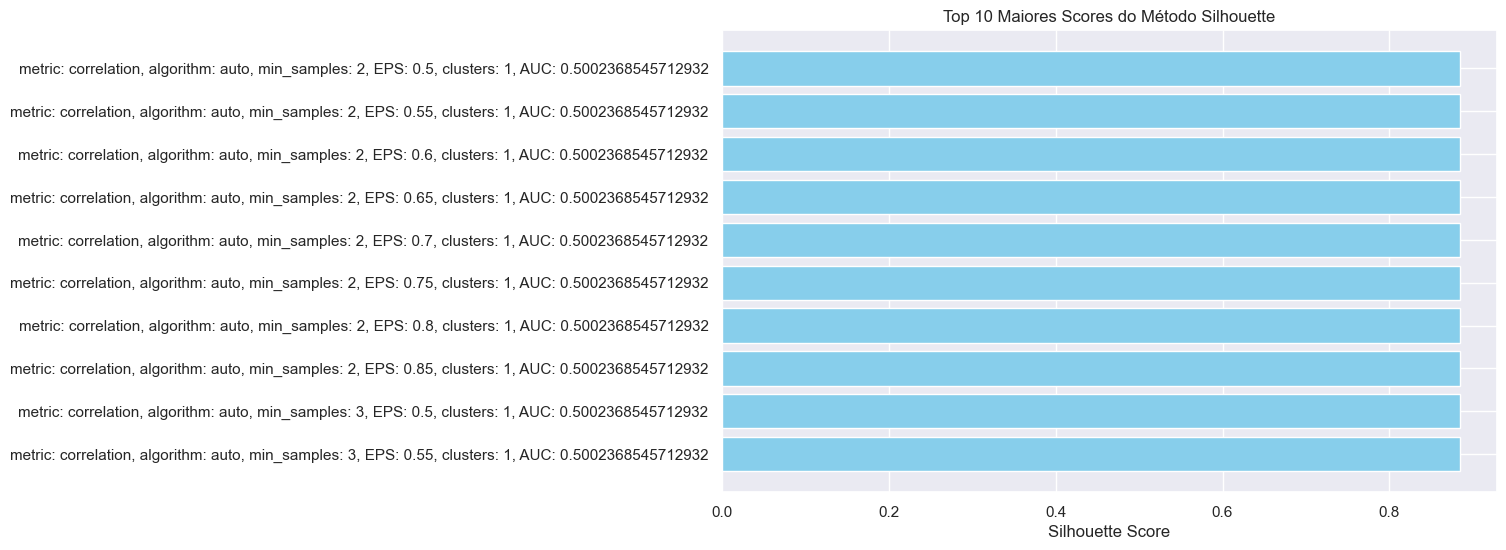

In [ ]:
plot_s_score(score_list)

0.7055211895516591


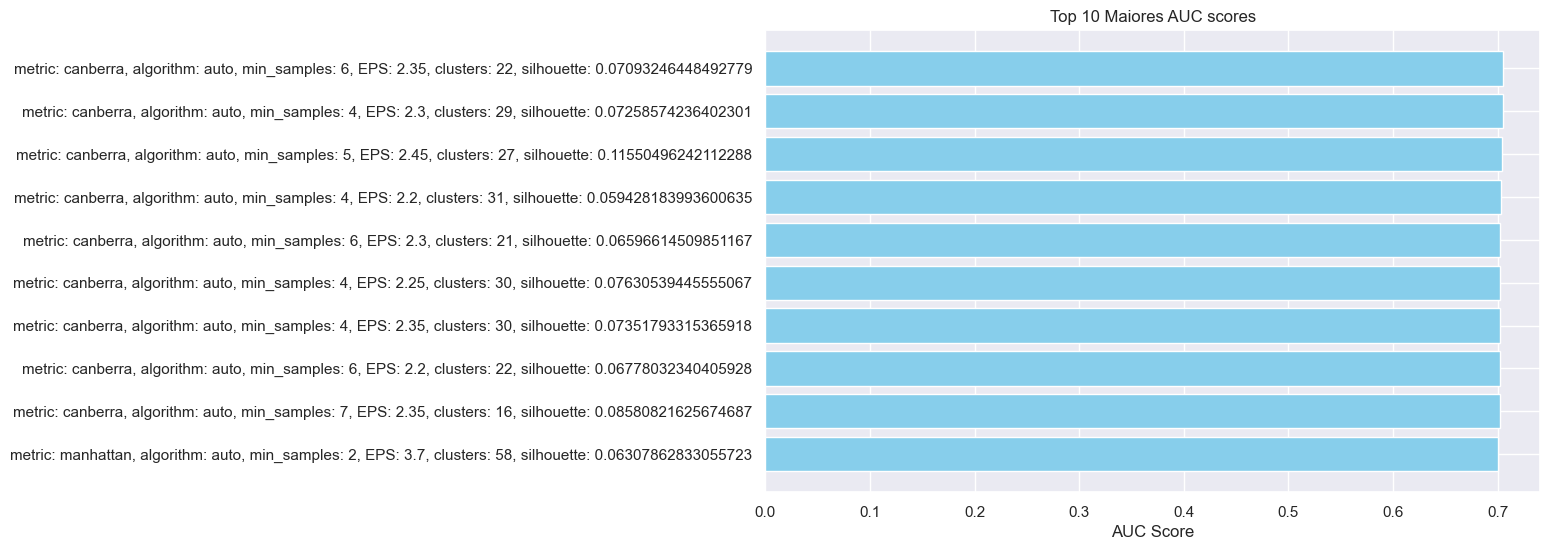

In [ ]:
plot_auc_score(score_list)

### Melhores resultados de Silhouette Score (do melhor pro pior, de cima pra baixo):

metric=cosine, algorithm=auto, min_samples=(menor possível), eps=0.85

metric=correlation, algorithm=auto, min_samples=(menor possível), eps=0.75

metric=braycurtis, algorithm=auto, min_samples=(menor possível), eps=0.5

OBS: Não coloquei muitas informações sobre estes testes, porque na época que eu fiz, eu não coletava tantas informações, e não pude reproduzi-los novamente porque não tinha feito com uma RANDOM_SEED. Os silhouette scores ficaram entre 0.8 e 0.9.

Apesar disso, as métricas acima, apresentaram uma curva ROC muito ruim(AUC próxima de 0.5), então decidi repetir o teste anterior focando na curva ROC, então, encontrei uma combinação com silhouette score alto, e que resultou uma boa curva ROC.

### Melhores resultados de AUC Score (do melhor pro pior, de cima pra baixo):

**AUC: 0.84**, metric=canberra, algorithm=auto, min_samples=(0.0020)*len(dados), eps=3.1, clusters: 26, silhouette score: 0.094, fração dos dados totais: 0.001, tamanho do subset: 2522, RANDOM_SEED: 1237

**AUC: 0.83**, metric=canberra, algorithm=auto, min_samples=(0.0016)*len(dados), eps=2.68, clusters: 34, fração dos dados totais: 0.001, tamanho do subset: 2522, RANDOM_SEED: 1237

**AUC: 0.819**, metric=canberra, algorithm=auto, min_samples=(0.0011)*len(dados), eps=3.2, clusters: 35, silhouette score: 0.1402, fração dos dados totais: 0.001, tamanho do subset: 2522, RANDOM_SEED: 5152357

OBS: Os multiplicadores de min_samples são valores aproximados. Os de 0.0016 por exemplo são na verdade 0,0015860428231562, 0.0020 = 0019825535289453.

## Teste Final

Escolhi os parâmetros que resultaram na melhor pontuação AUC(mas testei outros parâmetros exaustivamente também). Porém, o **min_sample** me pareceu que deveria ser proporcional à quantidade dos dados, pois na minha opinião, um número fixo não pode ser usado como padrão pra diferentes quantidades de dados.

Sobre o **metric**, eu pesquisei sobre as métricas e gostei bastante da métrica **chebyshev** porque ela dá muito peso às maiores diferenças, eu pensei que pelo fato de um pacote malicioso querer se parecer com um benigno, ele teria várias informações parecidas, mas algumas teriam uma diferença considerável que o **chebyshev** pudesse focar, porém, não obtive muito sucesso com esta métrica.

In [ ]:
#Definindo os parâmetros escolhidos
metric = 'canberra'
algorithm = 'auto'
min_samples = None #Irá ser definido mais abaixo no código
eps = 3.1

Não consegui fazer o processo com todos os dados de uma vez, por limitações de hardware e erros de software, por isso tive que usar apenas uma fração dos dados(o maior teste foi com 10% dos DADOS TOTAIS).

In [ ]:
RANDOM_SEED = 1237
np.random.seed(RANDOM_SEED)

In [ ]:
random_indexes = np.random.choice(norm_df.shape[0], int(norm_df.shape[0]*0.1), replace=False)
norm_df_subset = norm_df[random_indexes,:]
true_labels_subset = true_labels.iloc[random_indexes]

Verificação de quantos dados malignos e benignos estão presentes no subset, 0 = benignos, 1 = malignos.

In [ ]:
print(true_labels_subset.value_counts())

Label
0    209558
1     42642
Name: count, dtype: int64


Aqui eu defino a quantidade do **min_samples**, treino o modelo e coleto as labels geradas pelo DBSCAN.

In [ ]:
min_samples = max(2, int(len(norm_df_subset) * 0.0019825535289453))

In [ ]:
model_dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=metric, algorithm=algorithm, n_jobs=-1)
labels = model_dbscan.fit_predict(norm_df_subset)

predicoes = model_dbscan.labels_

Duração da modelagem: 50 minutos

Fiz uma lista de ruídos para saber quantos ruídos o modelo detectou.

In [ ]:
#Quantidade de ruídos resultantes do DBSCAN
noisy_list = list()
for x in model_dbscan.labels_:
    if x == -1:
        noisy_list.append(x)
print(len(noisy_list))        

47118


### Plots

Exibição de gráficos dos dados.

In [ ]:
def plot(X, labels, probabilities=None, parameters=None, ground_truth=False, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 4))
    labels = labels if labels is not None else np.ones(X.shape[0])
    probabilities = probabilities if probabilities is not None else np.ones(X.shape[0])
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    # The probability of a point belonging to its labeled cluster determines
    # the size of its marker
    proba_map = {idx: probabilities[idx] for idx in range(len(labels))}
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_index = np.where(labels == k)[0]
        for ci in class_index:
            ax.plot(
                X[ci, 0],
                X[ci, 1],
                "x" if k == -1 else "o",
                markerfacecolor=tuple(col),
                markeredgecolor="k",
                markersize=4 if k == -1 else 1 + 5 * proba_map[ci],
            )
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    preamble = "True" if ground_truth else "Estimated"
    title = f"{preamble} number of clusters: {n_clusters_}"
    if parameters is not None:
        parameters_str = ", ".join(f"{k}={v}" for k, v in parameters.items())
        title += f" | {parameters_str}"
    ax.set_title(title)
    plt.tight_layout()

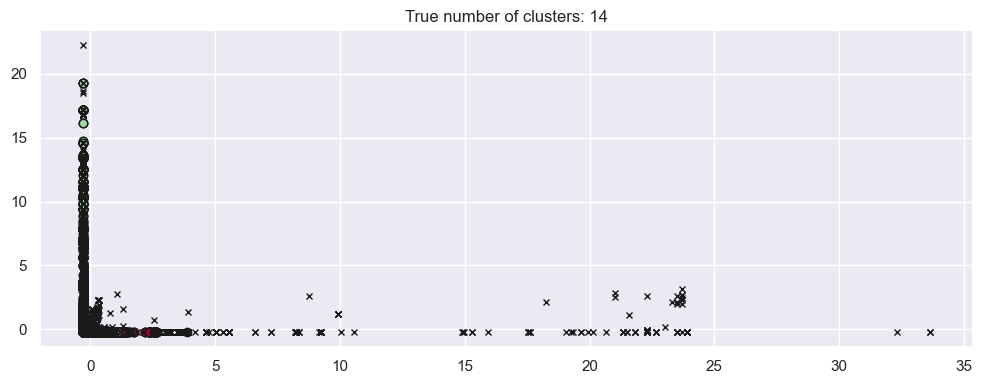

In [ ]:
plot(norm_df_subset, labels, ground_truth=True)

In [ ]:
def plot2(X, db, labels):    
    unique_labels = set(labels)
    core_samples_mask = np.zeros_like(labels, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = labels == k

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=14,
        )

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=6,
        )

    plt.title(f"Estimated number of clusters: {n_clusters_}")
    plt.show()

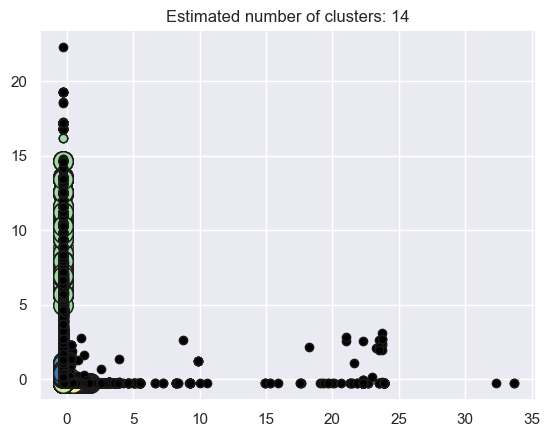

In [ ]:
plot2(norm_df_subset, model_dbscan, labels)

Eu não consegui enxergar muitas conclusões a partir destes plots iniciais, mas percebi que os ruídos estão muito próximos dos dados benignos, o que significa que eles realmente são muito parecidos e a detecção foi ruim. Além disso, percebi também que o número de clusters foi próximo da quantidade de clusters que dá um ótimo resultado ao KMeans, além de que também foi um número que se aproxima da quantidade de grupos dos dados(14 ataques e 1 grupo de dados benignos).

#### Curva ROC, Confusion Matrix, Overall Metrics

In [ ]:
def plot_roc_curve(y_true, y_score, max_fpr=1.0):
  fpr, tpr, thresholds = roc_curve(y_true, y_score)
  aucroc = roc_auc_score(y_true, y_score)
  print(aucroc)
  plt.plot(100*fpr[fpr < max_fpr], 100*tpr[fpr < max_fpr], label=f'ROC Curve (AUC = {aucroc:.4f})')
  plt.xlim(-2,102)
  plt.xlabel('FPR (%)')
  plt.ylabel('TPR (%)')
  plt.legend()
  plt.title('ROC Curve and AUCROC')

In [ ]:
def get_overall_metrics(y_true, y_pred):
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  acc = (tp+tn)/(tp+tn+fp+fn)
  tpr = tp/(tp+fn)
  fpr = fp/(fp+tn)
  precision = tp/(tp+fp)
  f1 = (2*tpr*precision)/(tpr+precision)
  return {'acc':acc,'tpr':tpr,'fpr':fpr,'precision':precision,'f1-score':f1}

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)
  group_counts = [f'{value:.0f}' for value in confusion_matrix(y_true, y_pred).ravel()]
  group_percentages = [f'{value*100:.2f}%' for value in confusion_matrix(y_true, y_pred).ravel()/np.sum(cm)]
  labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts, group_percentages)]
  labels = np.array(labels).reshape(2,2)
  sns.heatmap(cm, annot=labels, cmap='Oranges', xticklabels=['Predicted Benign', 'Predicted Malicious'], yticklabels=['Actual Benign', 'Actual Malicious'], fmt='')
  return

In [ ]:
DBSCAN_BEST_VALIDATION_THRESHOLD = 8

0.7834654721333774


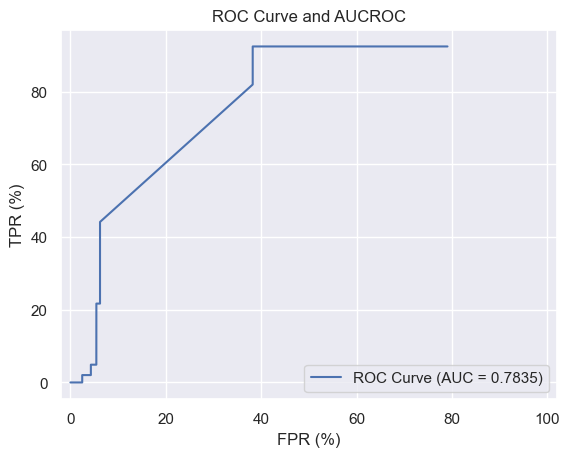

In [ ]:
plot_roc_curve(true_labels_subset, predicoes)

Consegui um resultado do AUC bastanta mediano, mesmo sendo a avaliação que mais testei e trabalhei.

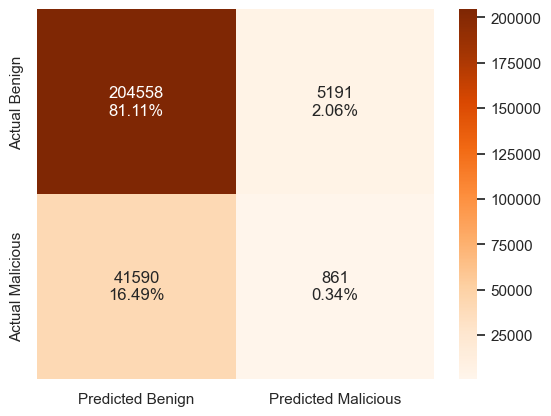

In [ ]:
plot_confusion_matrix(true_labels_subset, predicoes > DBSCAN_BEST_VALIDATION_THRESHOLD)

O maior desafio nesta tarefa foi ter uma boa pontuação de verdadeiro negativo, sempre que eu conseguia aumentar este valor, eu acaba aumentando o valor de falso negativo junto.

In [ ]:
get_overall_metrics(true_labels_subset, predicoes > DBSCAN_BEST_VALIDATION_THRESHOLD)

{'acc': 0.8145083267248215,
 'tpr': 0.020282207721844008,
 'fpr': 0.024748628122184136,
 'precision': 0.14226701916721746,
 'f1-score': 0.03550295857988166}

Sempre obtive um péssimo f1-score, não importa o quanto eu tentasse.

# Comentários extras

Todos os resultados foram piores que os resultados do KMeans que foi mostrado em aula e também os resultados que eu obtive no KMeans.



Eu confesso que ignorei bastante o número de clusters, visto que meu objetivo era transformar dados maliciosos em ruídos, então eu teoricamente não precisaria me preocupar com a quantidade de clusters, foi algo que eu demorei muito pra começar a fazer, porque o KMeans me fez dar muito valor à quantidade de clusters.

Uma das minhas maiores dificuldades foi porque tentei usar algumas lógicas do KMeans no DBSCAN e isso me atrapalhou bastante.

Eu não trabalhei muito na parte de tratamento de dados, não senti a necessidade de mudar muita coisa, a única coisa que fiz foi ter um conjunto com todos os dados, em vez de dividir eles, a divisão eu só fiz fracionando posteriormente, por questões de limitações de hardware como eu já falei anteriormente.

Após diversas tentativas, pude perceber o quão desafiador é a tarefa de usar IAs não supervisionadas, realmente tem uma diferença gigantesca, suas vantagens e desvantagens.

Eu não tenho certeza se compreendi bem as **metric** do DBSCAN, a que mais fazia sentido pra mim não foi a que obtive melhores resultados, mas talvez, tanto o **metric** quanto os outros parâmetros tem teoria por traz, então talvez se eu soubesse interpretar melhor essas teorias, eu teria feito uma decisão melhor do que simplesmente jogar várias possibilidades de combinações em vários *for* e registrar os melhores resultados.

Acredito também que eu deveria ter testado mais resultados na parte de testes de parâmetros, eu até testei um pouco o f1 lá, mas não tanto quanto o silhouette score e o AUC.

Um dos maiores aprendizados que obtive nesta tarefa foi não confiar em apenas um tipo de resultado, em diversos momentos o silhouette score e o AUC me "enganaram" quanto a eficiência do DBSCAN.